# Thesis: Alphafold3 Prediction Analysis
---

In [87]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy import stats

In [88]:
# Read in data
df = pd.read_csv('../data/af3_data.csv')
hal_df = pd.read_csv('../data/hal_data.csv')

# Create SMILES dataframe with SMILES columns
smiles_cols = [col for col in df.columns if 'SMILES' in col]
smiles_df = df[['PDB_ID', 'PDB_RELEASE_DATE'] + smiles_cols]

# Create CCD dataframe with CCD columns 
ccd_cols = [col for col in df.columns if 'CCD' in col]
ccd_df = df[['PDB_ID', 'PDB_RELEASE_DATE'] + ccd_cols]

In [89]:
smiles_df.head()

,PDB_ID,PDB_RELEASE_DATE,SMILES RMSD,SMILES DOCKQ SCORE,SMILES DOCKQ iRMSD,SMILES DOCKQ LRMSD,SMILES FRACTION DISORDERED,SMILES HAS_CLASH,SMILES IPTM,SMILES PTM,SMILES RANKING_SCORE
0,5HXB,2016-06-29,0.683,0.874,0.785,1.411,0.03,0,0.86,0.84,0.87
1,5T35,2017-03-08,2.350,0.578,1.736,5.485,0.10,0,0.75,0.82,0.81
2,6BN7,2018-05-30,0.601,0.226,4.539,12.923,0.06,0,0.85,0.85,0.88
3,6BOY,2018-05-30,0.765,0.092,6.875,18.065,0.16,0,0.60,0.66,0.69
4,6HM0,2019-01-16,0.317,NaN,NaN,NaN,0.09,0,0.87,0.88,0.92


In [90]:
ccd_df.head()

,PDB_ID,PDB_RELEASE_DATE,CCD RMSD,CCD DOCKQ SCORE,CCD DOCKQ iRMSD,CCD DOCKQ LRMSD,CCD FRACTION DISORDERED,CCD HAS_CLASH,CCD IPTM,CCD PTM,CCD RANKING_SCORE
0,5HXB,2016-06-29,0.674,0.867,0.783,1.286,0.03,0,0.87,0.84,0.88
1,5T35,2017-03-08,2.000,0.629,1.471,4.559,0.09,0,0.72,0.79,0.78
2,6BN7,2018-05-30,0.716,0.674,1.134,3.446,0.06,0,0.85,86.00,0.88
3,6BOY,2018-05-30,0.643,0.426,2.259,7.594,0.12,0,0.64,0.70,0.72
4,6HM0,2019-01-16,0.397,NaN,NaN,NaN,0.08,0,0.88,0.88,0.92


In [91]:
hal_df.head()

,PDB_ID,PDB_LINK,PDB_RELEASE_DATE,AF3_DIMERS DOCKQ SCORE,AF3_DIMERS iRMSD,AF3_DIMERS LRMSD,AF3_CONTEXT DOCKQ SCORE,AF3_CONTEXT iRMSD,AF3_CONTEXT LRMSD
0,5HXB,5HXB,2016-06-29,0.840,0.848,2.165,0.027,12.608,42.404
1,5T35,5T35,2017-03-08,0.014,12.765,49.502,0.019,16.143,37.396
2,6BOY,6BOY,2018-05-30,0.020,11.618,40.270,0.021,11.201,38.396
3,6HAX,6HAX,2019-06-12,0.019,10.682,43.182,0.050,9.364,22.506
4,6HAY,6HAY,2019-06-12,0.058,10.153,26.116,0.055,8.603,21.415


## Plot PBDID vs DockQ Scores

---

In [92]:
smiles_dockq_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ SCORE']].copy()
ccd_dockq_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD DOCKQ SCORE']].copy()
smiles_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES RMSD']].copy()
ccd_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD RMSD']].copy()
smiles_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES DOCKQ LRMSD']].copy()
ccd_lrmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD DOCKQ LRMSD']].copy()

# Drop rows with missing DockQ scores from both dataframes
smiles_dockq_df = smiles_dockq_df.dropna(subset=['SMILES DOCKQ SCORE'])
ccd_dockq_df = ccd_dockq_df.dropna(subset=['CCD DOCKQ SCORE'])
smiles_lrmsd_df = smiles_lrmsd_df.dropna(subset=['SMILES DOCKQ LRMSD'])
ccd_lrmsd_df = ccd_lrmsd_df.dropna(subset=['CCD DOCKQ LRMSD'])

# Create RMSD dataframes without conversion (will be handled in plot_scores)
smiles_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'SMILES RMSD']]
ccd_rmsd_df = df[['PDB_ID', 'PDB_RELEASE_DATE', 'CCD RMSD']]

smiles_dockq_df.head()

,PDB_ID,PDB_RELEASE_DATE,SMILES DOCKQ SCORE
0,5HXB,2016-06-29,0.874
1,5T35,2017-03-08,0.578
2,6BN7,2018-05-30,0.226
3,6BOY,2018-05-30,0.092
5,6HAY,2019-06-12,0.352


In [93]:
def plot_scores(df, score_type, title=None, add_threshold=False, threshold_value=0.23, save=True):
    """
    Generic plotting function for DockQ, RMSD, and LRMSD scores.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing PDB_ID, PDB_RELEASE_DATE and score columns
    score_type : str
        Type of score ('SMILES DockQ Score', 'CCD DockQ Score', 
                      'SMILES RMSD', 'CCD RMSD',
                      'SMILES DOCKQ LRMSD', 'CCD DOCKQ LRMSD')
    title : str, optional
        Title for the plot (defaults to f"{score_type} by PDB ID")
    add_threshold : bool, optional
        Whether to add a threshold line (default: False)
    threshold_value : float, optional
        Value for threshold line (default: 0.23, used for DockQ scores)
    save : bool, optional
        Whether to save the plot to data/plots directory (default: True)
    """
    plot_df = df.copy()
    
    # Map display names to column names
    column_mapping = {
        'SMILES DockQ Score': 'SMILES DOCKQ SCORE',
        'CCD DockQ Score': 'CCD DOCKQ SCORE',
        'SMILES RMSD': 'SMILES RMSD',
        'CCD RMSD': 'CCD RMSD',
        'SMILES DOCKQ LRMSD': 'SMILES DOCKQ LRMSD',
        'CCD DOCKQ LRMSD': 'CCD DOCKQ LRMSD'
    }

    column_name = column_mapping[score_type]
    
    # Set default title if none provided
    if title is None:
        title = f"{score_type} by PDB ID"
    
    # Convert PDB_RELEASE_DATE to datetime
    plot_df['PDB_RELEASE_DATE'] = pd.to_datetime(plot_df['PDB_RELEASE_DATE'])
    cutoff_date = pd.to_datetime('2021-09-30')
    
    # Create color list based on date
    colors = ['#1f77b4' if date > cutoff_date else '#ff7f0e' 
             for date in plot_df['PDB_RELEASE_DATE']]

    # Create plot
    plt.style.use('default')
    plt.figure(figsize=(15, 8))
    
    # Create bar plot with custom colors
    ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)
    
    # Add threshold line if requested
    if add_threshold:
        plt.axhline(y=threshold_value, color='red', linestyle='-', 
                   label=f'Acceptable Threshold ({threshold_value})')
    
    plt.title(title, fontsize=14, pad=20)
    plt.xlabel('PDB ID', fontsize=12)
    plt.ylabel(score_type, fontsize=12)
    
    # Add custom legend
    legend_elements = [
        Patch(facecolor='#ff7f0e', label='Before Sept 2021'),
        Patch(facecolor='#1f77b4', label='After Sept 2021')
    ]
    if add_threshold:
        legend_elements.append(
            plt.Line2D([0], [0], color='red', 
                      label=f'Acceptable Threshold ({threshold_value})')
        )
    plt.legend(handles=legend_elements)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    if save:
        # Create a filename-safe version of the title
        if title is None:
            filename = score_type.lower().replace(' ', '_')
        else:
            filename = title.lower().replace(' ', '_')
        
        # Remove any special characters
        filename = ''.join(c for c in filename if c.isalnum() or c in ['_', '-'])
        
        # Save the plot
        save_path = '../data/plots'
        plt.savefig(f'{save_path}/{filename}.png', dpi=300, bbox_inches='tight')
    
    plt.show()
    plt.close()

/var/folders/pm/dqslvjhd1ys7tm46jmn5nsk00000gn/T/ipykernel_74152/2262461142.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)


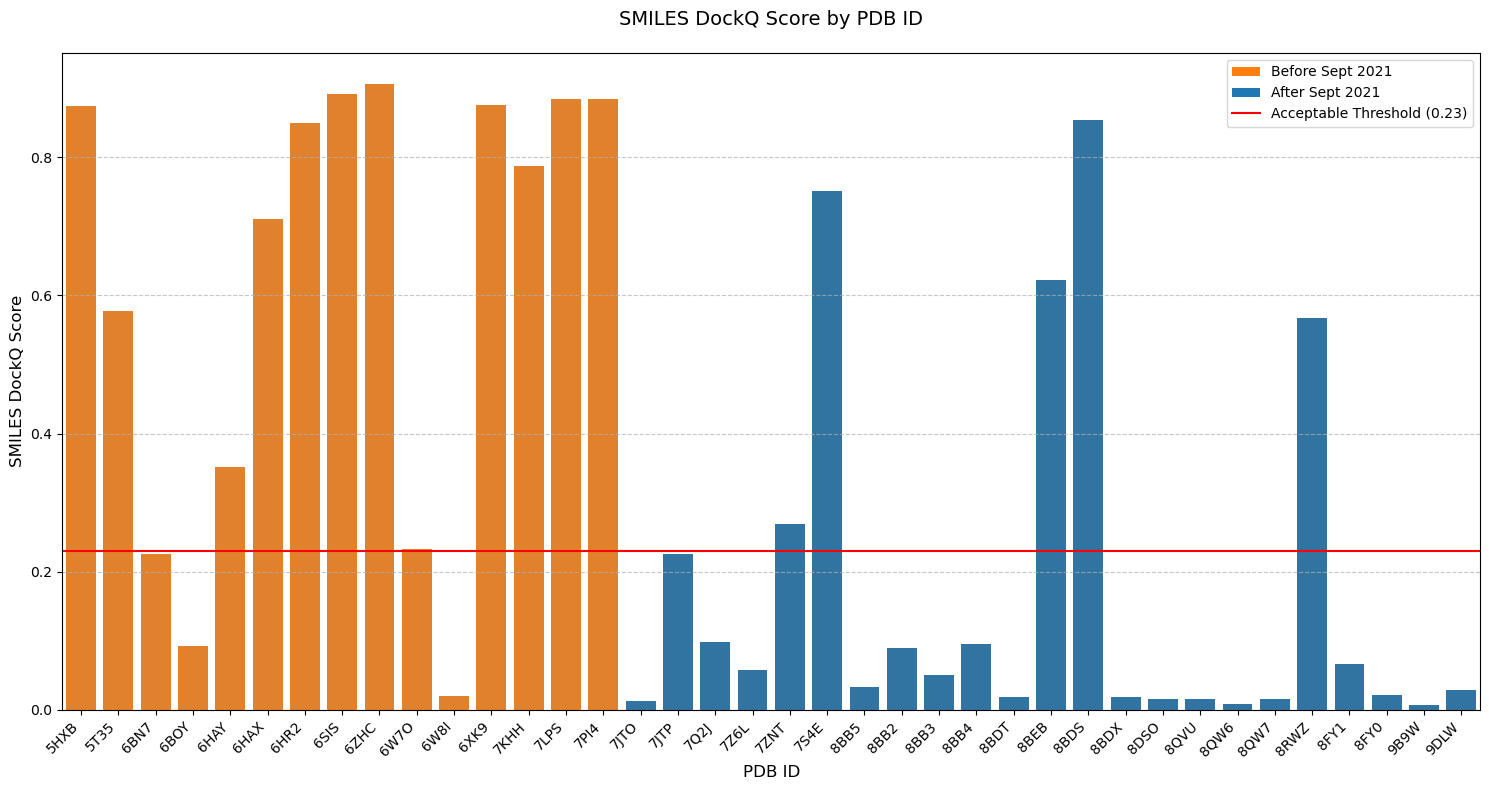

/var/folders/pm/dqslvjhd1ys7tm46jmn5nsk00000gn/T/ipykernel_74152/2262461142.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)


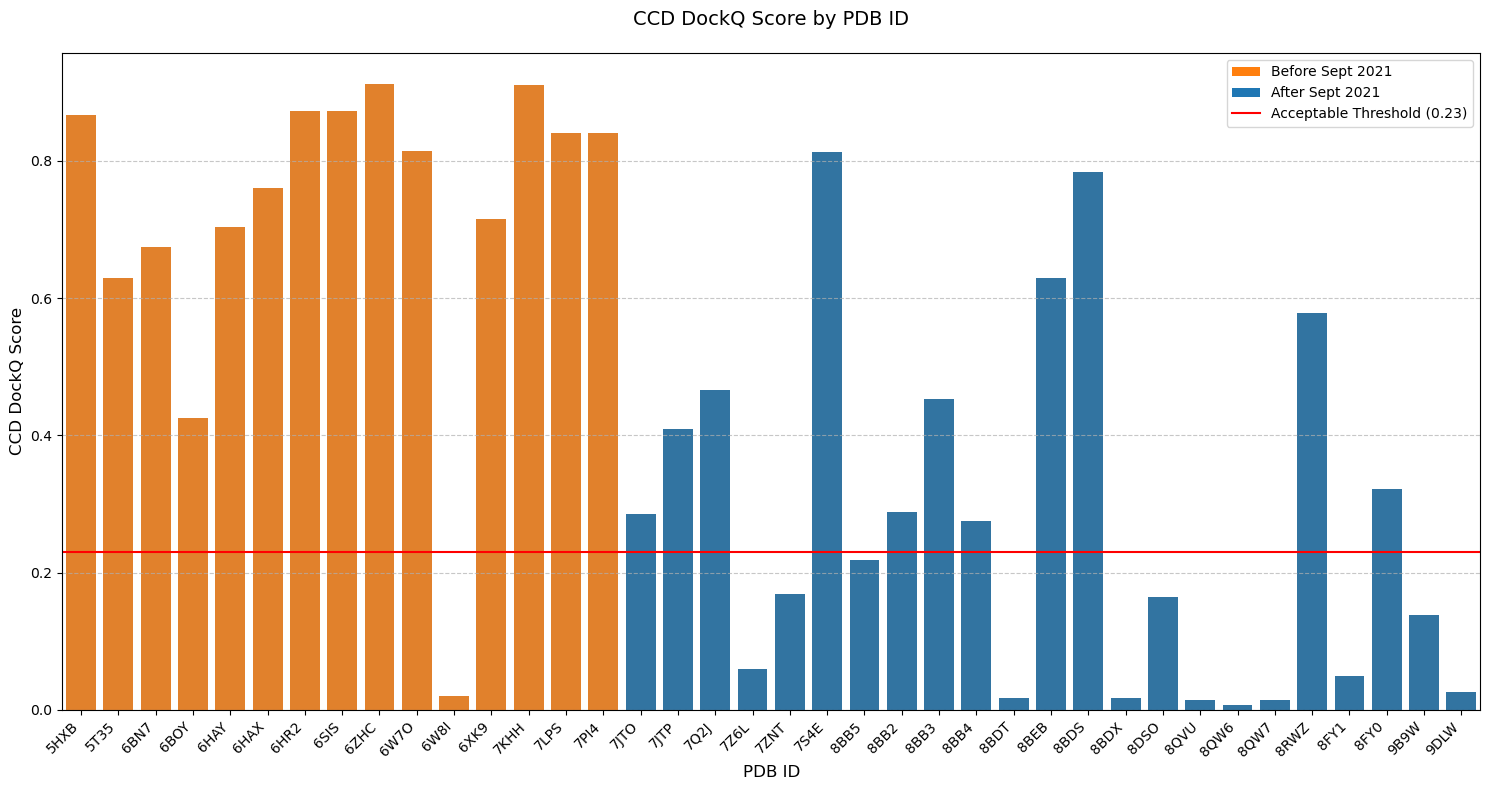

In [94]:
# For DockQ scores
plot_scores(smiles_dockq_df, 'SMILES DockQ Score', add_threshold=True, save=False)
plot_scores(ccd_dockq_df, 'CCD DockQ Score', add_threshold=True, save=False)

/var/folders/pm/dqslvjhd1ys7tm46jmn5nsk00000gn/T/ipykernel_74152/2262461142.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)


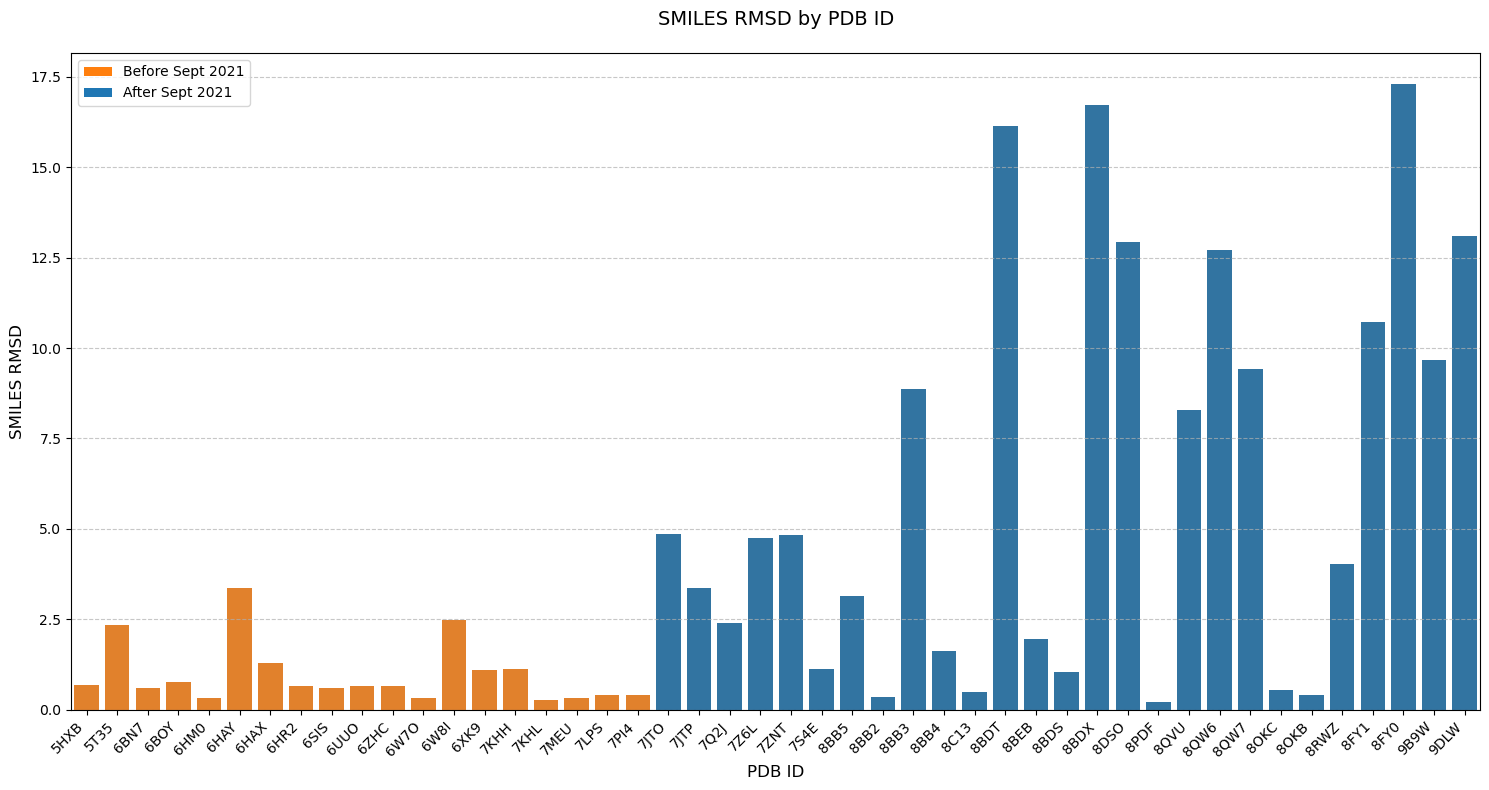

/var/folders/pm/dqslvjhd1ys7tm46jmn5nsk00000gn/T/ipykernel_74152/2262461142.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)


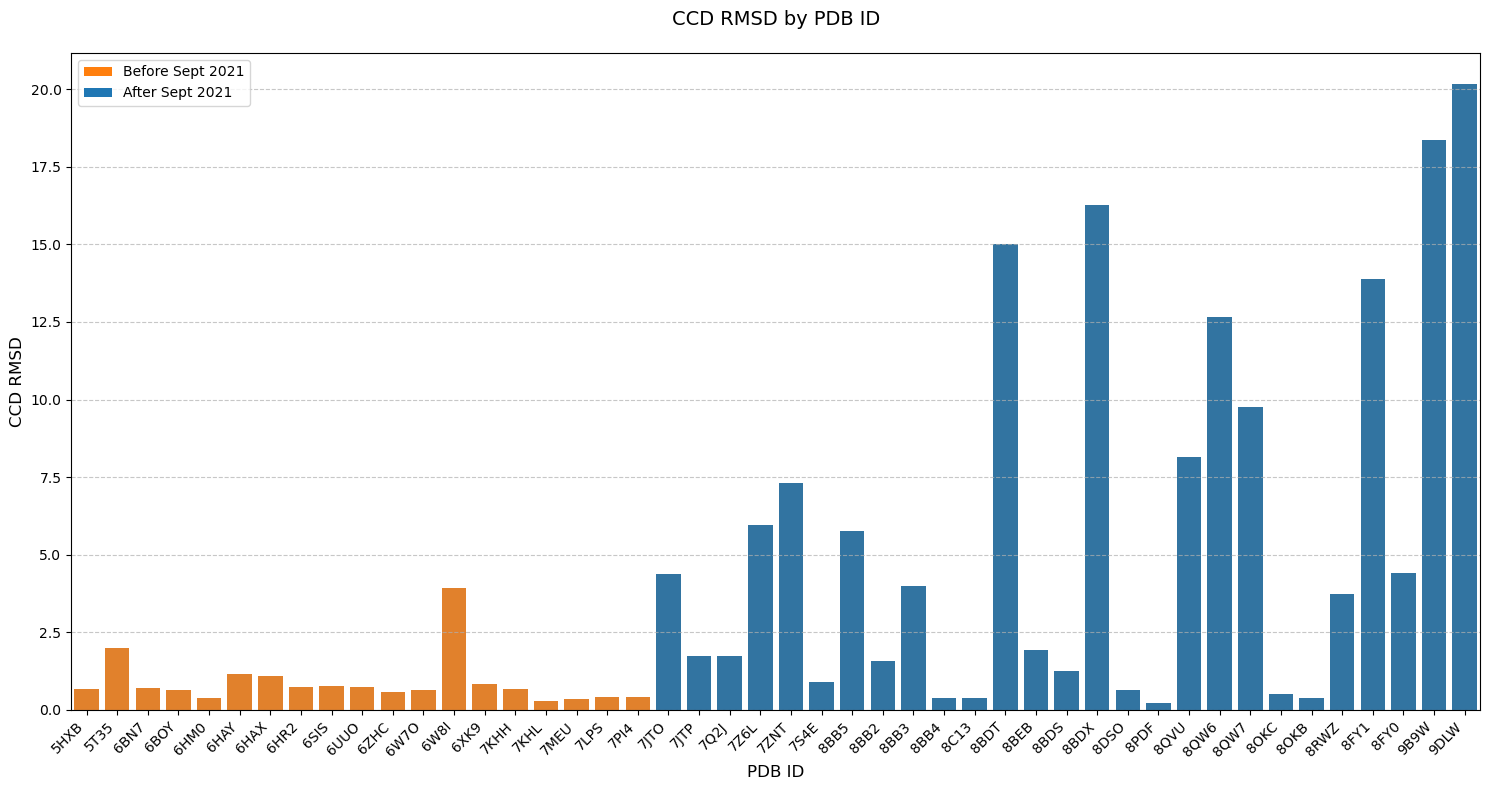

In [95]:
plot_scores(smiles_rmsd_df, 'SMILES RMSD', save=False)
plot_scores(ccd_rmsd_df, 'CCD RMSD', save=False)

/var/folders/pm/dqslvjhd1ys7tm46jmn5nsk00000gn/T/ipykernel_74152/2262461142.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)


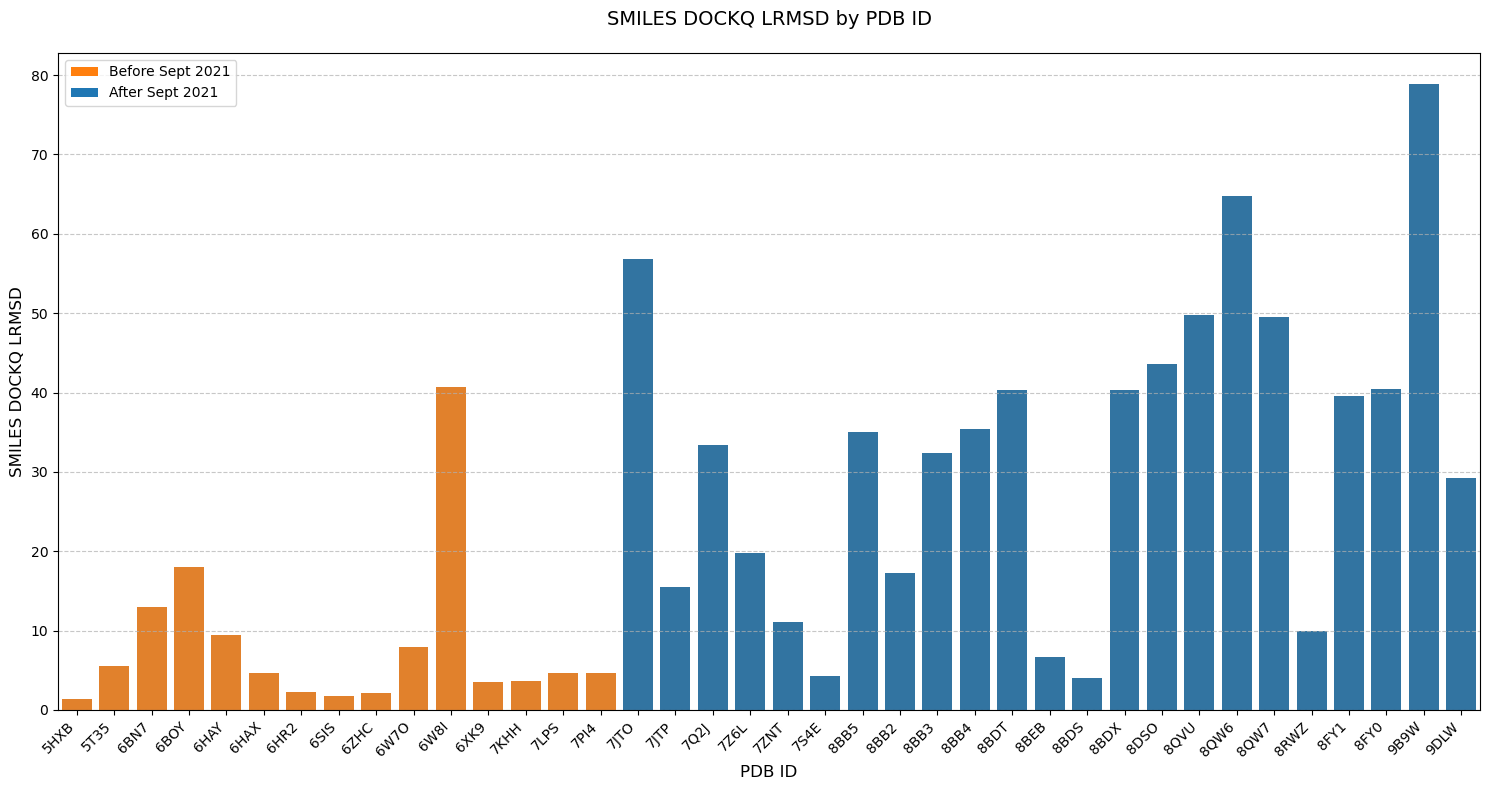

/var/folders/pm/dqslvjhd1ys7tm46jmn5nsk00000gn/T/ipykernel_74152/2262461142.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=plot_df, x='PDB_ID', y=column_name, palette=colors)


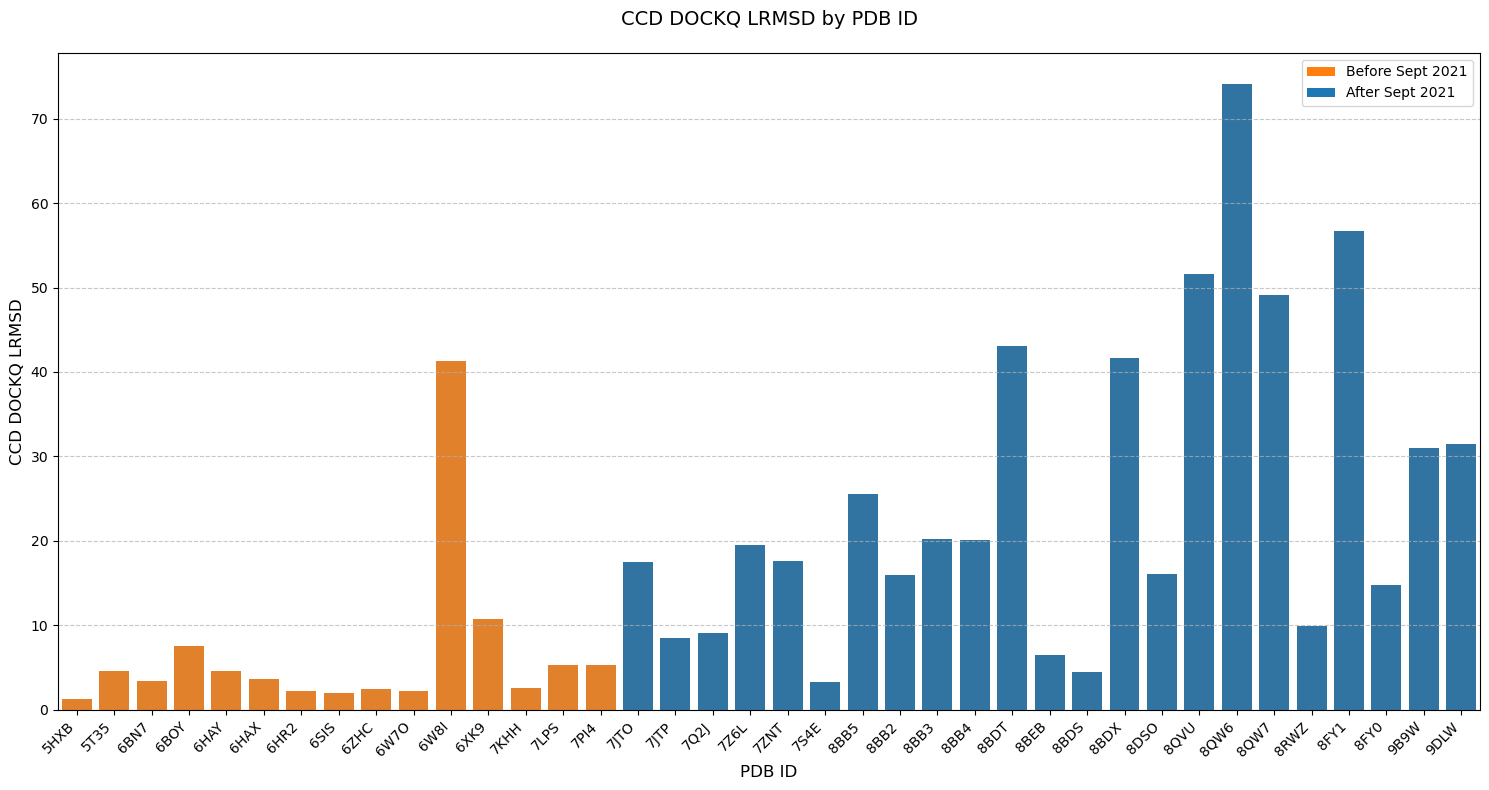

In [96]:
# For LRMSD scores
plot_scores(smiles_lrmsd_df, 'SMILES DOCKQ LRMSD', save=False)
plot_scores(ccd_lrmsd_df, 'CCD DOCKQ LRMSD', save=False)

## HAL Paper Results Comparasion

---

In [97]:
comparison_df = hal_df[['PDB_ID', 'PDB_RELEASE_DATE', 'AF3_DIMERS DOCKQ SCORE', 'AF3_DIMERS iRMSD', 'AF3_DIMERS LRMSD', 'AF3_CONTEXT DOCKQ SCORE', 'AF3_CONTEXT iRMSD', 'AF3_CONTEXT LRMSD']].copy()

# Merge CCD data
ccd_columns = ['PDB_ID', 'CCD DOCKQ SCORE', 'CCD DOCKQ iRMSD ', 'CCD DOCKQ LRMSD']
comparison_df = comparison_df.merge(df[ccd_columns], on='PDB_ID', how='left')

# Merge SMILES data
smiles_columns = ['PDB_ID', 'SMILES DOCKQ SCORE', 'SMILES DOCKQ iRMSD', 'SMILES DOCKQ LRMSD']
comparison_df = comparison_df.merge(df[smiles_columns], on='PDB_ID', how='left')

# Sort by release date (oldest to newest)
comparison_df = comparison_df.sort_values('PDB_RELEASE_DATE', ascending=True)

comparison_df.head()

,PDB_ID,PDB_RELEASE_DATE,AF3_DIMERS DOCKQ SCORE,AF3_DIMERS iRMSD,AF3_DIMERS LRMSD,AF3_CONTEXT DOCKQ SCORE,AF3_CONTEXT iRMSD,AF3_CONTEXT LRMSD,CCD DOCKQ SCORE,CCD DOCKQ iRMSD,CCD DOCKQ LRMSD,SMILES DOCKQ SCORE,SMILES DOCKQ iRMSD,SMILES DOCKQ LRMSD
0,5HXB,2016-06-29,0.840,0.848,2.165,0.027,12.608,42.404,0.867,0.783,1.286,0.874,0.785,1.411
1,5T35,2017-03-08,0.014,12.765,49.502,0.019,16.143,37.396,0.629,1.471,4.559,0.578,1.736,5.485
2,6BOY,2018-05-30,0.020,11.618,40.270,0.021,11.201,38.396,0.426,2.259,7.594,0.092,6.875,18.065
6,6BN7,2018-05-30,0.022,10.621,38.038,0.023,10.639,37.781,0.674,1.134,3.446,0.226,4.539,12.923
3,6HAX,2019-06-12,0.019,10.682,43.182,0.050,9.364,22.506,0.760,0.829,3.601,0.711,0.982,4.674


In [98]:
def plot_dockq_comparison(comparison_df, save=False, output_path=None):
    """
    Create a scatter plot comparing DockQ scores between different methods.
    
    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame containing columns:
        - PDB_ID
        - AF3_DIMERS DOCKQ SCORE
        - AF3_CONTEXT DOCKQ SCORE
        - CCD DOCKQ SCORE
        - SMILES DOCKQ SCORE
    save : bool, optional
        Whether to save the plot (default: False)
    output_path : str, optional
        Path where to save the plot if save=True
        
    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot figure
    """
    plt.figure(figsize=(15, 8))
    
    # Plot each set of scores with different markers for HAL paper results
    methods = {
        'Dimers (no ligand)': ('AF3_DIMERS DOCKQ SCORE', '#FF0000', '^'),  # Red triangles
        'Ligand: CCD': ('CCD DOCKQ SCORE', '#228B22', 'o'),  # Green circles
        'Ligand: SMILES': ('SMILES DOCKQ SCORE', '#FF8C00', 'o')  # Orange circles
    }
    
    for label, (column, color, marker) in methods.items():
        plt.scatter(range(len(comparison_df)), comparison_df[column], 
                   color=color, label=label, alpha=1.0, s=60, marker=marker)
    
    # Add the threshold line
    plt.axhline(y=0.23, color='black', linestyle='-', alpha=0.7, linewidth=2.5)
    
    # Create PDB ID labels with asterisks for dates after Sept 2021
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
                 for pdb, date in zip(comparison_df['PDB_ID'], comparison_df['PDB_RELEASE_DATE'])]
    
    plt.title('AlphaFold3 PROTAC Prediction Comparison', 
              fontsize=16, pad=20, weight='bold')
    plt.ylabel('DockQ', fontsize=14, weight='bold')
    plt.xlabel('PDB ID', fontsize=14, weight='bold')
    plt.ylim(0, 1.0)
    
    # Add x-axis labels with asterisks
    plt.xticks(range(len(comparison_df)), pdb_labels, 
               rotation=45, ha='right', fontsize=10)
    
    # Add legend for methods and asterisk
    handles, labels = plt.gca().get_legend_handles_labels()
    asterisk_handle = Line2D([0], [0], marker='*', color='w', 
                            markerfacecolor='black', markersize=10, 
                            label='After Sept 2021')
    handles.append(asterisk_handle)
    
    plt.legend(handles=handles, loc='upper right', fontsize=10, framealpha=0.9)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    
    if save and output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

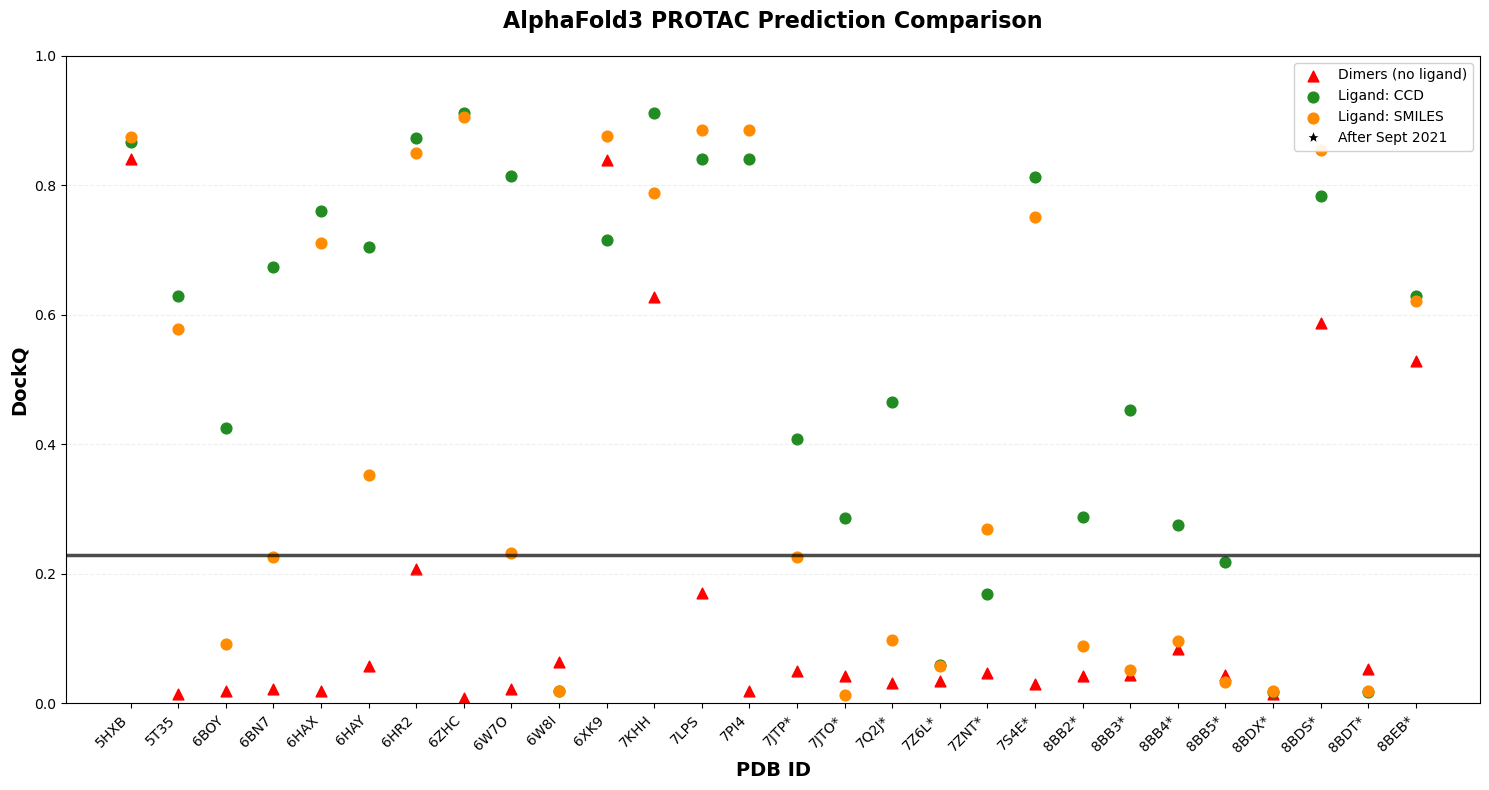

In [99]:
fig = plot_dockq_comparison(comparison_df)
plt.show()

In [100]:
def plot_dockq_comparison(comparison_df, save=False, output_path=None):
    """
    Create a scatter plot comparing DockQ scores between different methods.
    
    Parameters:
    -----------
    comparison_df : pandas.DataFrame
        DataFrame containing columns:
        - PDB_ID
        - AF3_DIMERS DOCKQ SCORE
        - AF3_CONTEXT DOCKQ SCORE
        - CCD DOCKQ SCORE
        - SMILES DOCKQ SCORE
    save : bool, optional
        Whether to save the plot (default: False)
    output_path : str, optional
        Path where to save the plot if save=True
        
    Returns:
    --------
    matplotlib.figure.Figure
        The generated plot figure
    """
    plt.figure(figsize=(15, 8))
    
    # Plot each set of scores with different markers for HAL paper results
    methods = {
        'Dimers (No Ligand)': ('AF3_DIMERS DOCKQ SCORE', '#A9A9A9', 'o'),  # Red triangles
        'Ligand: CCD': ('CCD DOCKQ SCORE', '#003366', 'o'),  # Green circles
        'Ligand: SMILES': ('SMILES DOCKQ SCORE', '#FFC325', 'o')  # Orange circles
    }
    
    for label, (column, color, marker) in methods.items():
        plt.scatter(range(len(comparison_df)), comparison_df[column], 
                   color=color, label=label, alpha=1.0, s=60, marker=marker)
    
    # Add the threshold line
    plt.axhline(y=0.23, color='black', linestyle='--', alpha=0.7, linewidth=1)
    
    # Create PDB ID labels with asterisks for dates after Sept 2021
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
                 for pdb, date in zip(comparison_df['PDB_ID'], comparison_df['PDB_RELEASE_DATE'])]
    
    plt.title('DockQ Scores: Comparing Experimental Structures with AlphaFold3 Predictions', 
              fontsize=16, pad=20)
    plt.ylabel('DockQ Score', fontsize=14)
    plt.xlabel('PDB ID', fontsize=14)
    plt.ylim(0, 1.0)
    
    # Add x-axis labels with asterisks
    plt.xticks(range(len(comparison_df)), pdb_labels, 
               rotation=45, ha='center', fontsize=10)
    
    # Add legend for methods and asterisk
    handles, labels = plt.gca().get_legend_handles_labels()
    
    plt.legend(handles=handles, loc='upper right', fontsize=10, framealpha=0.9)
    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.2)
    
    if save and output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')
    
    return plt.gcf()

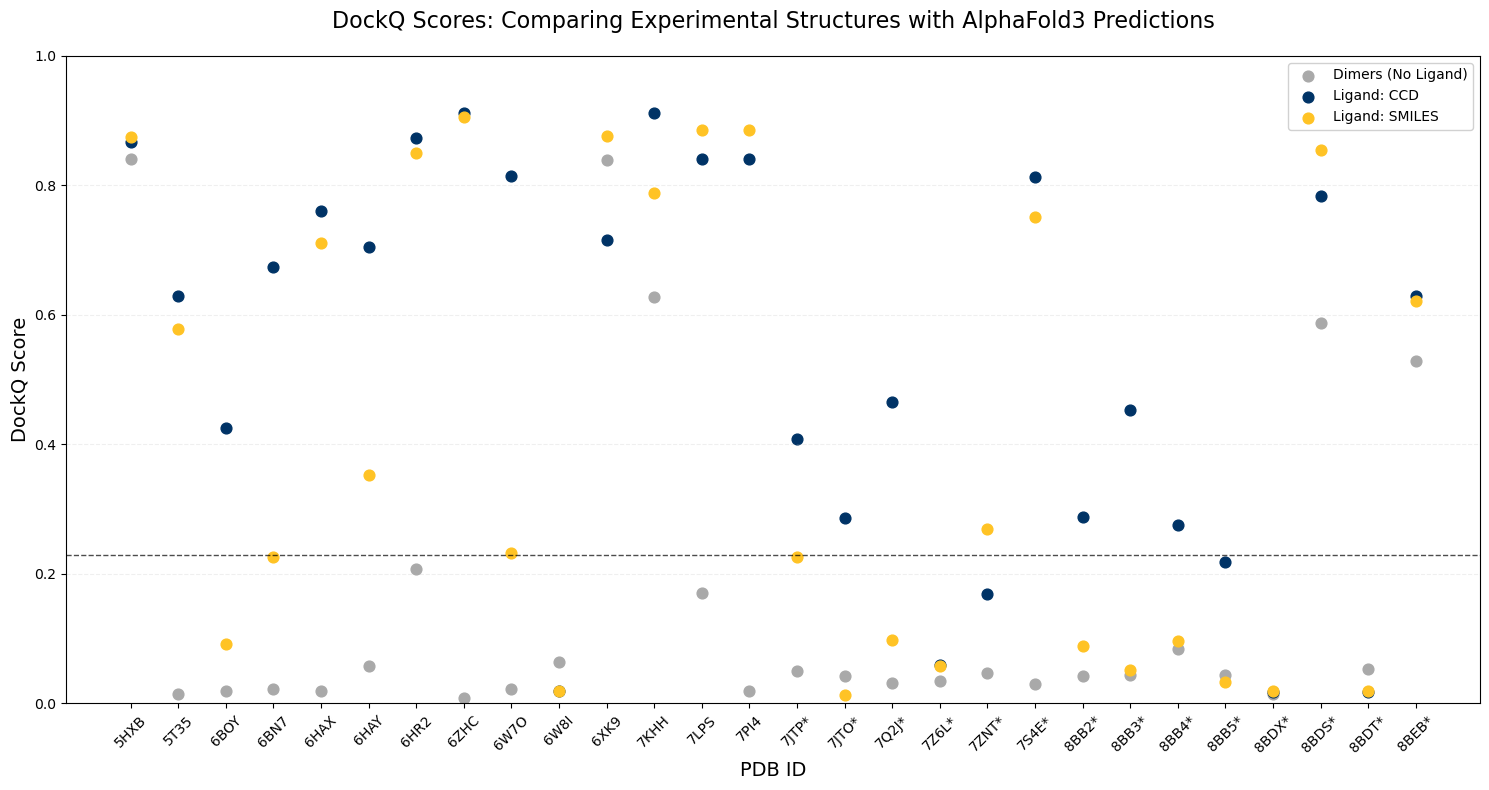

In [101]:
fig = plot_dockq_comparison(comparison_df)
plt.show()

In [112]:
def plot_dockq_comparison(comparison_df, save=False, output_path=None):
    """
    Create a scatter plot comparing DockQ scores between different methods.
    """
    # Use scientific style
    plt.style.use('default')  # Reset to default style first
    
    # Create figure with higher DPI for better quality
    plt.figure(figsize=(15, 8), dpi=300)
    
    # Define professional color scheme (colorblind-friendly)
    methods = {
        'No Ligand': ('AF3_DIMERS DOCKQ SCORE', '#A9A9A9', 'o'),  # Blue
        'CCD Ligand': ('CCD DOCKQ SCORE', '#66CCEE', 'o'),  # Light blue
        'SMILES Ligand': ('SMILES DOCKQ SCORE', '#4477AA', 'o')  # Green
    }
    
    for label, (column, color, marker) in methods.items():
        plt.scatter(range(len(comparison_df)), comparison_df[column], 
                   color=color, label=label, alpha=0.8, s=80, 
                   marker=marker, edgecolors='black', linewidth=0.5)
    
    # Add threshold line with label
    plt.axhline(y=0.23, color='black', linestyle='--', alpha=0.7, linewidth=1,
                label='Acceptable Threshold (0.23)')
    
    # Create PDB ID labels
    cutoff_date = pd.to_datetime('2021-09-30')
    pdb_labels = [f"{pdb}*" if pd.to_datetime(date) > cutoff_date else pdb 
                 for pdb, date in zip(comparison_df['PDB_ID'], comparison_df['PDB_RELEASE_DATE'])]
    
    # Improve title and labels with clear, descriptive text
    plt.title('Comparison of AlphaFold3 PROTAC Structure Predictions with Experimental Data', 
              fontsize=16, pad=20, fontweight='bold')
    plt.ylabel('DockQ Score', fontsize=14, fontweight='bold')
    plt.xlabel('PDB Identifier', fontsize=14, fontweight='bold')
    
    # Set axis limits and ticks
    plt.ylim(0.0, 1.0)  # Slightly extend y-axis for better visualization
    plt.xlim(-0.5, len(comparison_df) - 0.5)  # Adjust x-axis limits
    
    # Format tick labels
    plt.xticks(range(len(comparison_df)), pdb_labels, 
               rotation=45, ha='center', fontsize=10)
    plt.yticks(fontsize=10)
    
    # Add grid for better readability
    plt.grid(True, linestyle='--', alpha=0.3, which='major')
    
    # Improve legend
    legend = plt.legend(
        title='Prediction Method',
        title_fontsize=12,
        fontsize=10,
        loc='upper right',
        framealpha=0.7,
        edgecolor='black'
    )
    
    # Add annotation for the dagger symbol
    plt.figtext(0.99, 0.01, '* Structures released after AlphaFold3 training cutoff (Sept 2021)',
                ha='right', fontsize=8, style='italic')
    
    # Add spines
    ax = plt.gca()
    ax.spines['top'].set_visible(0.5)
    ax.spines['right'].set_visible(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_linewidth(0.5)
    
    # Adjust layout
    plt.tight_layout()
    
    if save and output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight', format='pdf')
    
    return plt.gcf()

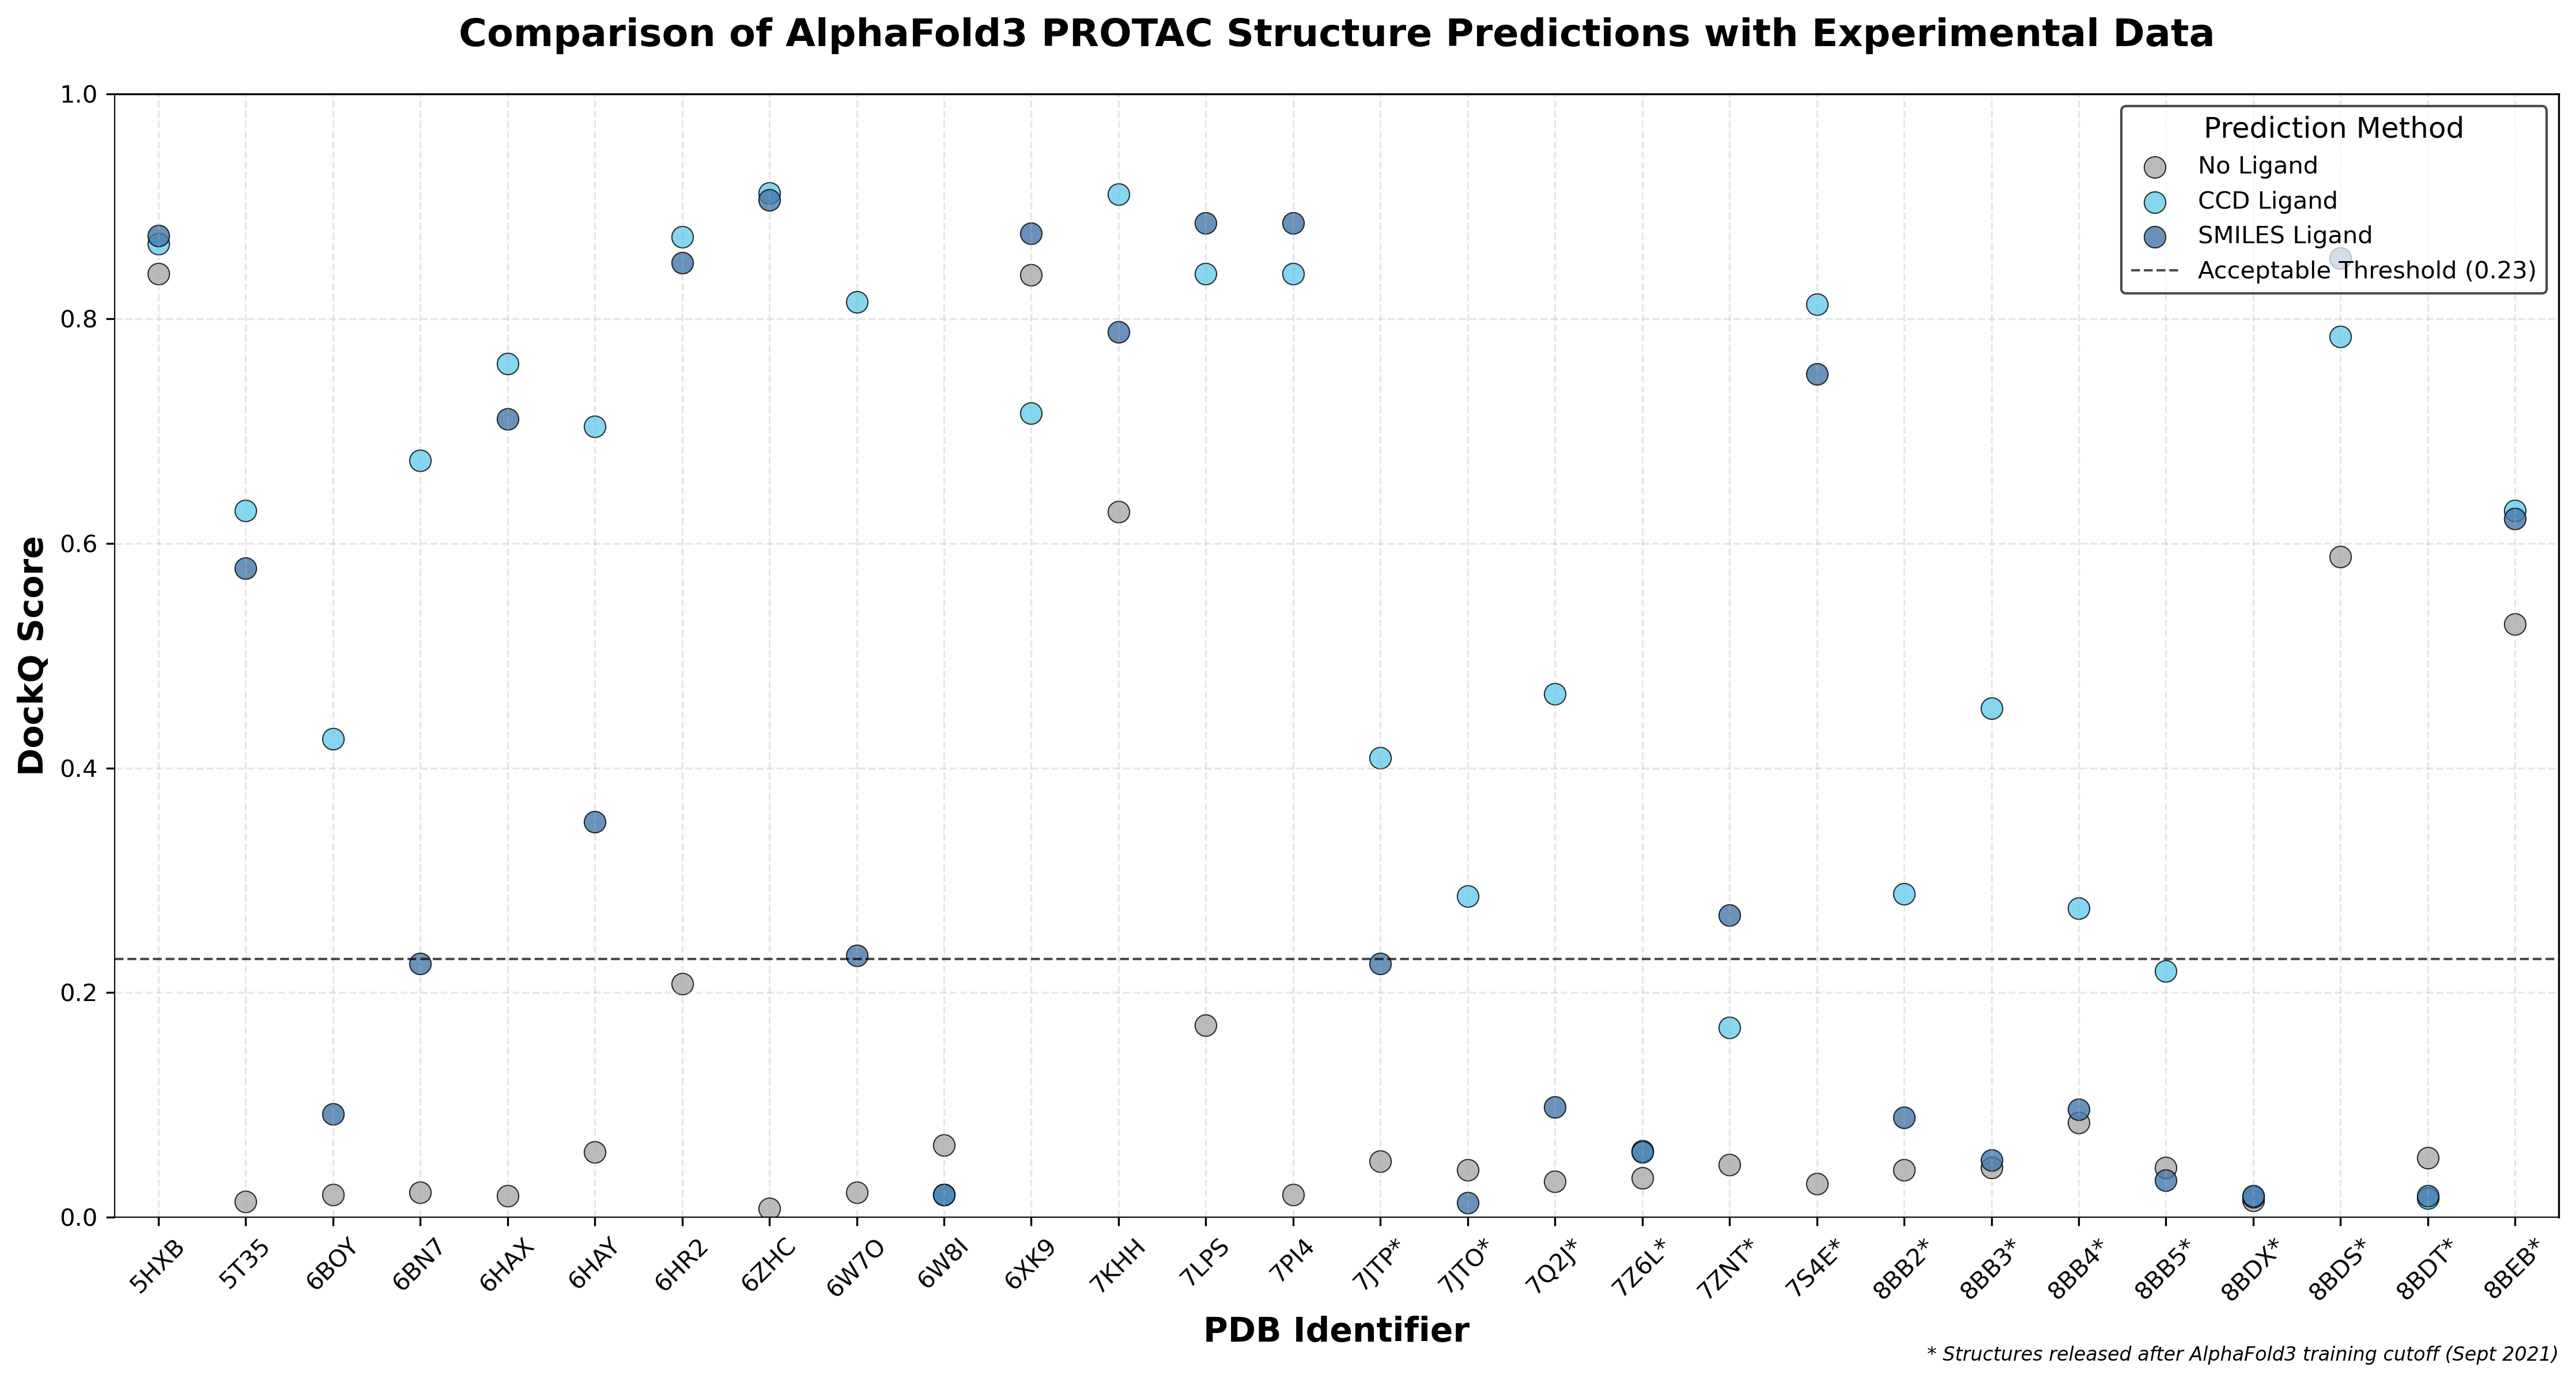

In [113]:
fig = plot_dockq_comparison(comparison_df)
plt.show()

## Spearman Rank Correlations

---

In [104]:
def calculate_spearman_correlations(df):
    """
    Calculate Spearman rank correlations between specified pairs of variables.
    Returns both correlation coefficients and p-values.
    """
    # Define pairs to compare
    pairs = [
        ('SMILES DOCKQ SCORE', 'SMILES PTM', 'SMILES DockQ vs PTM'),
        ('CCD DOCKQ SCORE', 'CCD PTM', 'CCD DockQ vs PTM'),
        ('SMILES DOCKQ SCORE', 'SMILES IPTM', 'SMILES DockQ vs iPTM'),
        ('CCD DOCKQ SCORE', 'CCD IPTM', 'CCD DockQ vs iPTM'),
        ('SMILES DOCKQ SCORE', 'SMILES RMSD', 'SMILES DockQ vs RMSD'),
        ('CCD DOCKQ SCORE', 'CCD RMSD', 'CCD DockQ vs RMSD')
    ]
    
    results = []
    
    for var1, var2, label in pairs:
        # Remove rows with NaN values for this pair
        pair_df = df[[var1, var2]].dropna()
        
        # Calculate Spearman correlation
        correlation, p_value = stats.spearmanr(pair_df[var1], pair_df[var2])
        
        # Store results
        results.append({
            'Comparison': label,
            'Correlation': correlation,
            'P-value': p_value,
            'Sample Size': len(pair_df)
        })
    
    # Create results dataframe
    results_df = pd.DataFrame(results)
    
    # Format the results
    results_df['Correlation'] = results_df['Correlation'].round(3)
    results_df['P-value'] = results_df['P-value'].round(4)
    
    return results_df

In [105]:
correlation_results = calculate_spearman_correlations(df)

# Display results in a nicely formatted table
print("\nSpearman Rank Correlations:")
print("============================")
print(correlation_results.to_string(index=False))


Spearman Rank Correlations:
          Comparison  Correlation  P-value  Sample Size
 SMILES DockQ vs PTM        0.578   0.0001           38
    CCD DockQ vs PTM        0.593   0.0001           38
SMILES DockQ vs iPTM        0.661   0.0000           38
   CCD DockQ vs iPTM        0.734   0.0000           38
SMILES DockQ vs RMSD       -0.766   0.0000           38
   CCD DockQ vs RMSD       -0.769   0.0000           38


In [106]:
def plot_correlation_pairs(df):
    """
    Create scatter plots for each correlation pair.
    """
    pairs = [
        ('SMILES DOCKQ SCORE', 'SMILES PTM', 'SMILES DockQ vs PTM'),
        ('CCD DOCKQ SCORE', 'CCD PTM', 'CCD DockQ vs PTM'),
        ('SMILES DOCKQ SCORE', 'SMILES IPTM', 'SMILES DockQ vs iPTM'),
        ('CCD DOCKQ SCORE', 'CCD IPTM', 'CCD DockQ vs iPTM'),
        ('SMILES DOCKQ SCORE', 'SMILES RMSD', 'SMILES DockQ vs RMSD'),
        ('CCD DOCKQ SCORE', 'CCD RMSD', 'CCD DockQ vs RMSD')
    ]
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()
    
    for idx, (var1, var2, title) in enumerate(pairs):
        # Get data without NaN values
        plot_df = df[[var1, var2]].dropna()
        
        # Calculate correlation
        corr, _ = stats.spearmanr(plot_df[var1], plot_df[var2])
        
        # Create scatter plot
        axes[idx].scatter(plot_df[var1], plot_df[var2], alpha=0.6)
        axes[idx].set_xlabel(var1)
        axes[idx].set_ylabel(var2)
        axes[idx].set_title(f'{title}\nρ = {corr:.3f}')
        axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

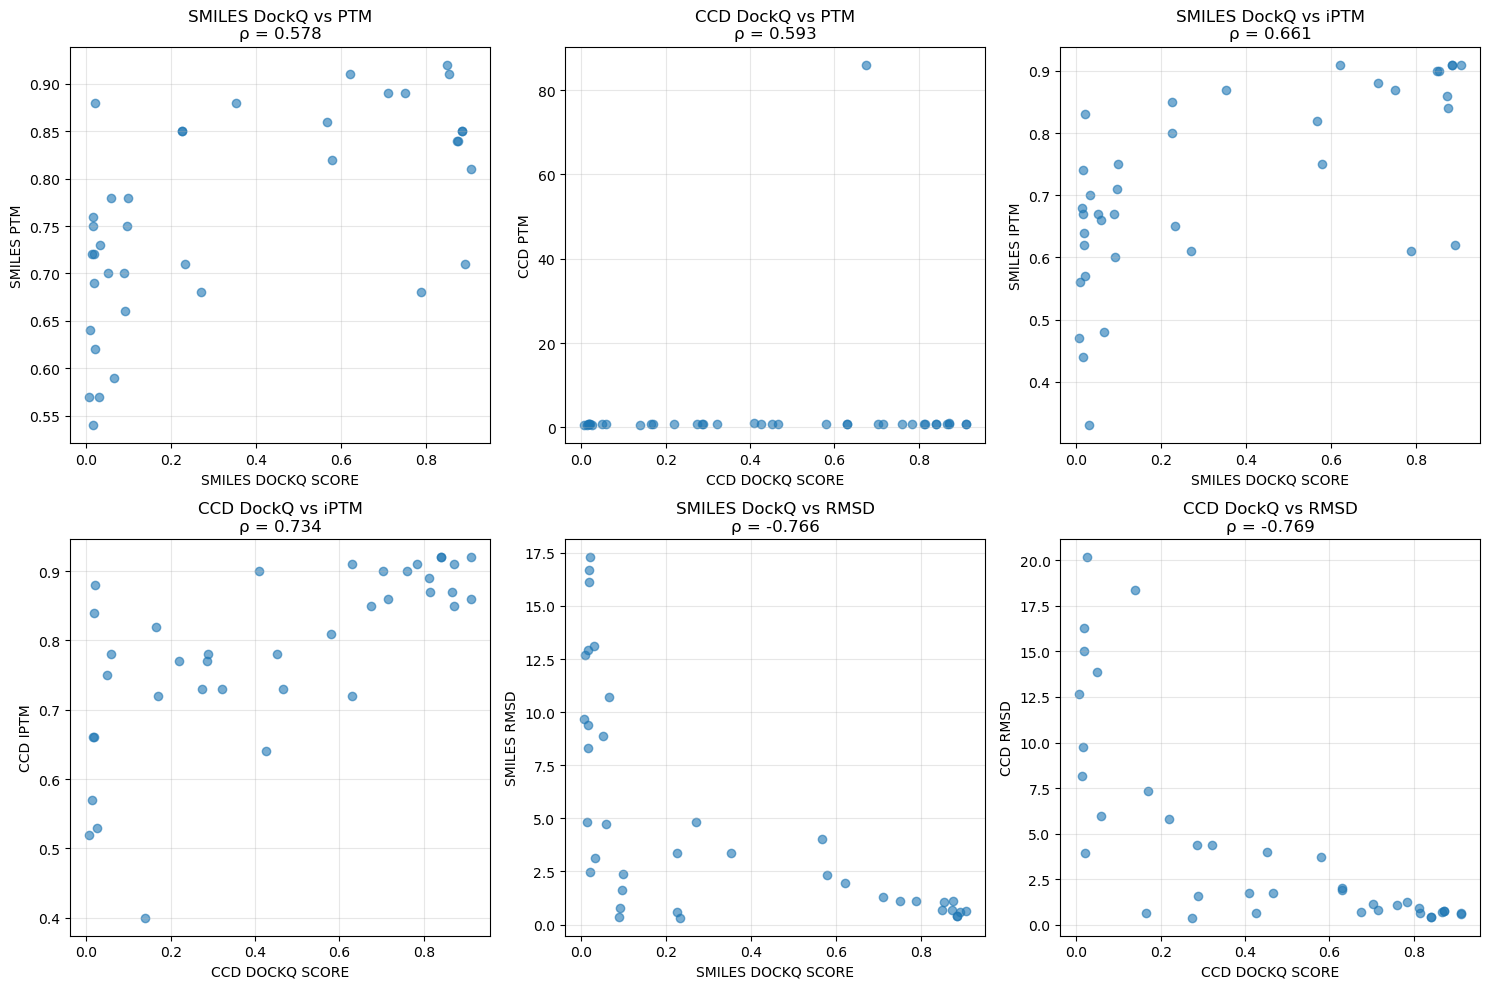

In [107]:
plot_correlation_pairs(df)